<a href="https://colab.research.google.com/github/SriVidyaYeluripati/mlph_w24/blob/dev/sheet10_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sheet 10

## 1 Optimal Transport

### (a) Optimal Transport Problem

#### Objective and Constraints
The objective of the optimal transport problem is to minimize the total transportation cost. Assuming the transportation costs are linear in both the transported mass and the distance, the optimization problem can be written as:

$$
\min_{P_{ij}} \sum_{i,j} P_{ij} \|x_i - y_j\|
$$

Subject to the following constraints:

1. Supply constraint at sources:
   $$
   \sum_j P_{ij} = a_i, \quad \forall i
   $$

2. Demand constraint at sinks:
   $$
   \sum_i P_{ij} = b_j, \quad \forall j
   $$

3. Non-negativity of transported mass:
   $$
   P_{ij} \geq 0, \quad \forall i, j
   $$

#### Why Straight Lines?
Transportation along straight lines minimizes the Euclidean distance $\|x_i - y_j\|$ between sources and sinks. Since the cost is directly proportional to both the distance and the mass, straight-line paths minimize the total cost by ensuring the shortest possible route is taken.


### (b) Optimal Transport Problem as a Linear Program

The optimization problem from part (a) can be rewritten in the form of a linear program as follows:

#### Objective Function
Minimize the total transportation cost:
$$
\min_{P_{ij}} \sum_{i,j} P_{ij} \|x_i - y_j\|
$$

This can be written in linear form:
$$
\min \mathbf{c}^T \mathbf{P},
$$
where:
- $\mathbf{P}$ is the vector of transported masses $P_{ij}$,
- $\mathbf{c}$ is the cost vector containing the transportation distances $\|x_i - y_j\|$.

#### Constraints
1. **Supply Constraints** (ensuring total mass at sources is transported):
   $$
   \sum_j P_{ij} = a_i, \quad \forall i
   $$

   This can be expressed as:
   $$
   \mathbf{A}_{\text{source}} \mathbf{P} = \mathbf{a},
   $$
   where $\mathbf{A}_{\text{source}}$ is a matrix that enforces the sum of transported mass from each source $i$.

2. **Demand Constraints** (ensuring total mass received at sinks equals their demand):
   $$
   \sum_i P_{ij} = b_j, \quad \forall j
   $$

   This can be expressed as:
   $$
   \mathbf{A}_{\text{sink}} \mathbf{P} = \mathbf{b},
   $$
   where $\mathbf{A}_{\text{sink}}$ is a matrix that enforces the sum of transported mass to each sink $j$.

3. **Non-negativity Constraints** (mass cannot be negative):
   $$
   P_{ij} \geq 0, \quad \forall i, j
   $$

   In matrix form:
   $$
   \mathbf{P} \geq 0.
   $$

#### Equality Constraints as Inequalities
Equality constraints can be expressed using inequalities:
$$
\mathbf{A} \mathbf{P} \leq \mathbf{b}, \quad -\mathbf{A} \mathbf{P} \leq -\mathbf{b}.
$$
However, for simplicity, the original equality constraints are retained directly.

The resulting linear program is:
$$
\min \mathbf{c}^T \mathbf{P},
$$
subject to:
$$
\mathbf{A}_{\text{source}} \mathbf{P} = \mathbf{a},
$$
$$
\mathbf{A}_{\text{sink}} \mathbf{P} = \mathbf{b},
$$
$$
\mathbf{P} \geq 0.
$$


Optimal transportation cost: 0.6707468352771471


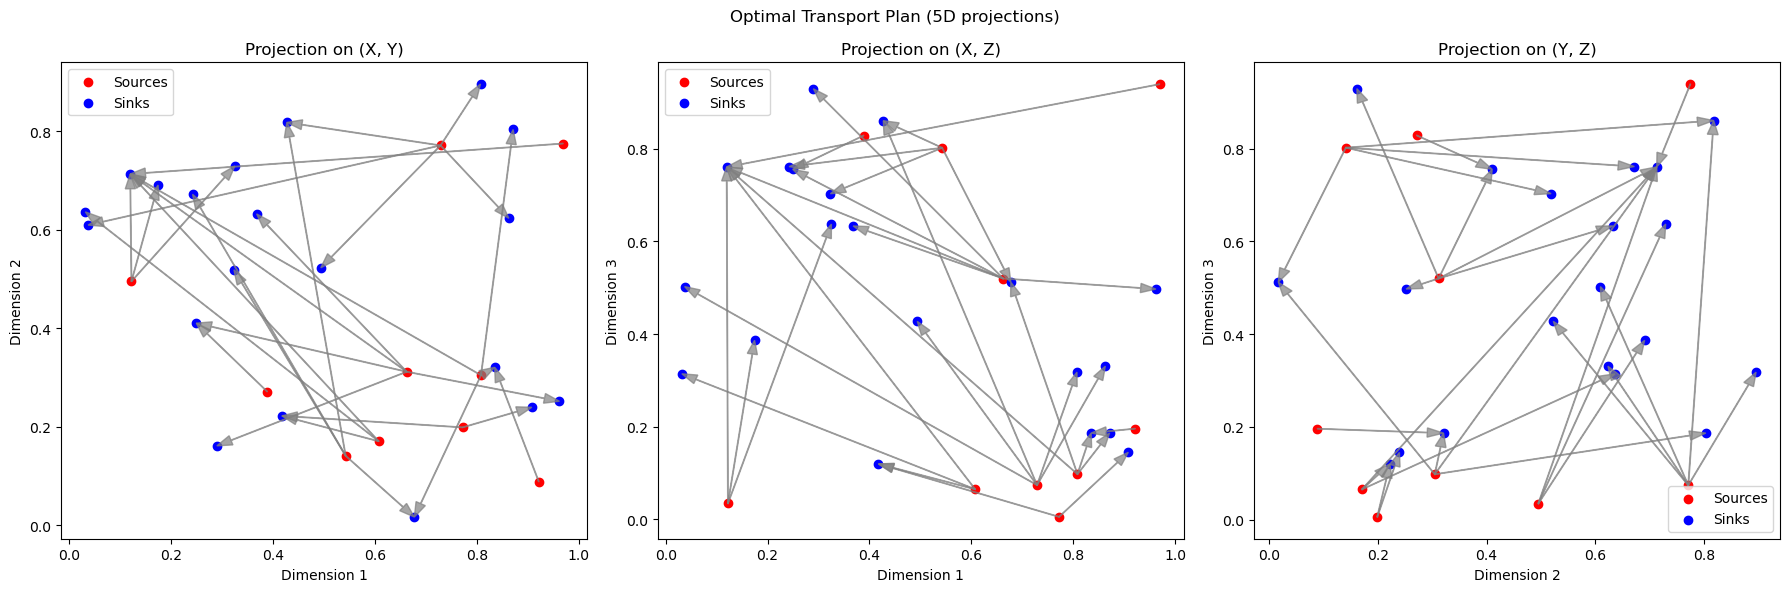

In [ ]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Problem setup
d = 5  # dimensionality
num_sources = 10
num_sinks = 20

np.random.seed(42)
mass_sources = np.random.random(num_sources)
mass_sinks = np.random.random(num_sinks)
mass_sources /= np.sum(mass_sources)
mass_sinks /= np.sum(mass_sinks)

coords_sources = np.random.rand(num_sources, d)
coords_sinks = np.random.rand(num_sinks, d)

# Calculate cost matrix
cost_matrix = np.zeros((num_sources, num_sinks))
for i in range(num_sources):
    for j in range(num_sinks):
        cost_matrix[i, j] = np.linalg.norm(coords_sources[i] - coords_sinks[j])

# Flatten the cost matrix
c = cost_matrix.flatten()

# Equality constraints for supply (sources) and demand (sinks)
A_eq = []
b_eq = []

# Supply constraints (rows)
for i in range(num_sources):
    row = np.zeros(num_sources * num_sinks)
    row[i * num_sinks:(i + 1) * num_sinks] = 1
    A_eq.append(row)
    b_eq.append(mass_sources[i])

# Demand constraints (columns)
for j in range(num_sinks):
    col = np.zeros(num_sources * num_sinks)
    col[j::num_sinks] = 1
    A_eq.append(col)
    b_eq.append(mass_sinks[j])

A_eq = np.array(A_eq)
b_eq = np.array(b_eq)

# Bounds for transported mass (non-negativity)
bounds = [(0, None) for _ in range(num_sources * num_sinks)]

# Solve the linear program
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

# Check if the solution is successful
if result.success:
    print(f"Optimal transportation cost: {result.fun}")

    # Extract the transport plan
    transport_plan = result.x.reshape(num_sources, num_sinks)

    # Visualize the result
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Projections to visualize different spatial axes
    projections = [(0, 1), (0, 2), (1, 2)]
    titles = ["Projection on (X, Y)", "Projection on (X, Z)", "Projection on (Y, Z)"]

    for ax, proj, title in zip(axes, projections, titles):
        i, j = proj
        coords_sources_proj = coords_sources[:, [i, j]]
        coords_sinks_proj = coords_sinks[:, [i, j]]

        # Plot sources and sinks
        ax.scatter(coords_sources_proj[:, 0], coords_sources_proj[:, 1], color='red', label='Sources')
        ax.scatter(coords_sinks_proj[:, 0], coords_sinks_proj[:, 1], color='blue', label='Sinks')

        # Plot transportation plan with arrows
        for src_idx in range(num_sources):
            for sink_idx in range(num_sinks):
                if transport_plan[src_idx, sink_idx] > 1e-6:  # Significant transport
                    ax.arrow(
                        coords_sources_proj[src_idx, 0], coords_sources_proj[src_idx, 1],
                        coords_sinks_proj[sink_idx, 0] - coords_sources_proj[src_idx, 0],
                        coords_sinks_proj[sink_idx, 1] - coords_sources_proj[src_idx, 1],
                        color='gray', alpha=0.7, head_width=0.02, head_length=0.03, length_includes_head=True
                    )

        ax.set_title(title)
        ax.set_xlabel(f"Dimension {i + 1}")
        ax.set_ylabel(f"Dimension {j + 1}")
        ax.legend()

    plt.suptitle("Optimal Transport Plan (5D projections)")
    plt.tight_layout()
    plt.show()
else:
    print("Optimization failed!")


### (d) Intersecting Transportation Routes Are Never Optimal

#### Assumptions
1. The transportation cost is **linear** in the transportation distance.
2. There are two intersecting transportation routes:
   - Route 1: From source \( S_1 \) to sink \( T_1 \).
   - Route 2: From source \( S_2 \) to sink \( T_2 \).
3. The intersection occurs such that the routes cross each other in space.

#### Proof
Let \( \|S_1 - T_1\| \) and \( \|S_2 - T_2\| \) denote the Euclidean distances for the two original routes. Because the routes intersect, the following alternative routes can be considered:
- Route \( S_1 \to T_2 \): Distance \( \|S_1 - T_2\| \).
- Route \( S_2 \to T_1 \): Distance \( \|S_2 - T_1\| \).

The transportation cost for the original intersecting routes is:
$$
C_{\text{original}} = \|S_1 - T_1\| + \|S_2 - T_2\|.
$$

The transportation cost for the alternative non-intersecting routes is:
$$
C_{\text{alternative}} = \|S_1 - T_2\| + \|S_2 - T_1\|.
$$

By the **triangle inequality**, which states that the direct path between two points is always shorter or equal to any indirect path passing through an intermediate point, we derive the following:
   $$
   \|S_1 - T_1\| + \|S_2 - T_2\| \geq \|S_1 - T_2\| + \|S_2 - T_1\|.
   $$

The equality holds if and only if the points \( S_1, S_2, T_1, T_2 \) are collinear, which is not the case for intersecting routes. Thus:
$$
C_{\text{alternative}} < C_{\text{original}}.
$$

#### Therefore
Since the transportation cost is strictly lower for the non-intersecting routes, the intersecting transportation plan is suboptimal. Therefore, intersecting transportation routes are never optimal when the transportation cost is linear in the distance.

#### Note on 5D Projections
This analysis does not imply that crossings observed in our 5D projections are problematic. In the actual 5D space, the "crossing" lines seen in the projections do not intersect; they only appear to cross due to the dimensional reduction to 2D planes. Hence, these crossings are artifacts of the projection and do not violate the optimality of the solution.


## 2 Flow matching for generative modeling

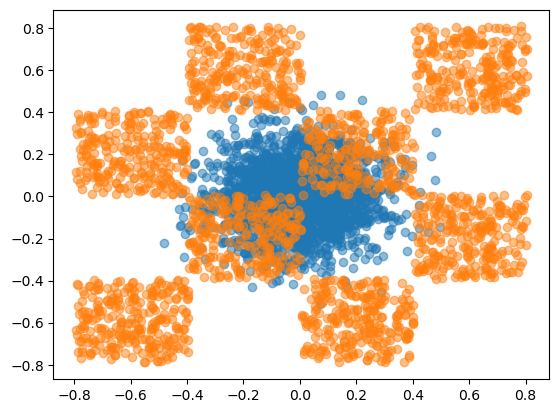

In [ ]:
import torch
import matplotlib.pyplot as plt

def generate_checkerboard_sample(num_samples=10, field_size=0.4, num_fields=2, center=True):
    x = torch.rand(num_samples, 2) * field_size
    offset = torch.randint(0, num_fields, (num_samples, 2)) * field_size * 2
    diagonal_shift = torch.randint(0, num_fields, (num_samples, 1)) * field_size
    x += offset + diagonal_shift

    if center:
        x -= torch.mean(x, dim=0)

    return x

base_distribution_std = 0.15
num_samples = 2000
x = torch.randn(num_samples, 2) * base_distribution_std
y = generate_checkerboard_sample(num_samples=num_samples)

# show points
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='base distribution')
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label='checkerboard distribution')
plt.show()

cuda


  3%|█▉                                                                           | 1009/40000 [00:15<11:42, 55.50it/s]

Epoch [1000/40000], Loss: 0.1076


  5%|███▊                                                                         | 2011/40000 [00:32<09:59, 63.38it/s]

Epoch [2000/40000], Loss: 0.1035


  8%|█████▊                                                                       | 3004/40000 [00:49<10:06, 61.01it/s]

Epoch [3000/40000], Loss: 0.1006


 10%|███████▋                                                                     | 4007/40000 [01:05<08:08, 73.69it/s]

Epoch [4000/40000], Loss: 0.1031


 13%|█████████▋                                                                   | 5011/40000 [01:22<09:28, 61.53it/s]

Epoch [5000/40000], Loss: 0.1014


 15%|███████████▌                                                                 | 6007/40000 [01:38<09:17, 61.01it/s]

Epoch [6000/40000], Loss: 0.1031


 18%|█████████████▌                                                               | 7013/40000 [01:53<07:52, 69.74it/s]

Epoch [7000/40000], Loss: 0.0994


 20%|███████████████▍                                                             | 8010/40000 [02:09<08:06, 65.75it/s]

Epoch [8000/40000], Loss: 0.1014


 23%|█████████████████▎                                                           | 9007/40000 [02:25<08:26, 61.20it/s]

Epoch [9000/40000], Loss: 0.0993


 25%|███████████████████                                                         | 10010/40000 [02:41<08:19, 60.08it/s]

Epoch [10000/40000], Loss: 0.1028


 28%|████████████████████▉                                                       | 11008/40000 [02:56<07:15, 66.57it/s]

Epoch [11000/40000], Loss: 0.1005


 30%|██████████████████████▊                                                     | 12005/40000 [03:12<07:50, 59.48it/s]

Epoch [12000/40000], Loss: 0.0999


 33%|████████████████████████▋                                                   | 13005/40000 [03:28<07:04, 63.57it/s]

Epoch [13000/40000], Loss: 0.1013


 35%|██████████████████████████▌                                                 | 14005/40000 [03:44<07:31, 57.51it/s]

Epoch [14000/40000], Loss: 0.1017


 38%|████████████████████████████▌                                               | 15007/40000 [04:01<07:11, 57.87it/s]

Epoch [15000/40000], Loss: 0.1018


 40%|██████████████████████████████▍                                             | 16009/40000 [04:18<06:21, 62.96it/s]

Epoch [16000/40000], Loss: 0.1012


 43%|████████████████████████████████▎                                           | 17007/40000 [04:34<06:26, 59.55it/s]

Epoch [17000/40000], Loss: 0.1001


 45%|██████████████████████████████████▏                                         | 18009/40000 [04:50<06:03, 60.52it/s]

Epoch [18000/40000], Loss: 0.1006


 48%|████████████████████████████████████                                        | 19010/40000 [05:07<05:43, 61.14it/s]

Epoch [19000/40000], Loss: 0.1024


 50%|██████████████████████████████████████                                      | 20010/40000 [05:23<05:34, 59.78it/s]

Epoch [20000/40000], Loss: 0.1014


 53%|███████████████████████████████████████▉                                    | 21009/40000 [05:40<05:21, 59.09it/s]

Epoch [21000/40000], Loss: 0.1011


 55%|█████████████████████████████████████████▊                                  | 22007/40000 [05:57<05:05, 58.81it/s]

Epoch [22000/40000], Loss: 0.1006


 58%|███████████████████████████████████████████▋                                | 23008/40000 [06:14<04:44, 59.75it/s]

Epoch [23000/40000], Loss: 0.1021


 60%|█████████████████████████████████████████████▌                              | 24004/40000 [06:31<04:32, 58.76it/s]

Epoch [24000/40000], Loss: 0.1014


 63%|███████████████████████████████████████████████▌                            | 25007/40000 [06:47<04:17, 58.13it/s]

Epoch [25000/40000], Loss: 0.1024


 65%|█████████████████████████████████████████████████▍                          | 26005/40000 [07:04<04:03, 57.59it/s]

Epoch [26000/40000], Loss: 0.1019


 68%|███████████████████████████████████████████████████▎                        | 27007/40000 [07:21<03:36, 59.96it/s]

Epoch [27000/40000], Loss: 0.1017


 70%|█████████████████████████████████████████████████████▏                      | 28008/40000 [07:38<03:22, 59.12it/s]

Epoch [28000/40000], Loss: 0.0999


 73%|███████████████████████████████████████████████████████                     | 29006/40000 [07:54<03:16, 55.97it/s]

Epoch [29000/40000], Loss: 0.0991


 75%|█████████████████████████████████████████████████████████                   | 30006/40000 [08:11<02:44, 60.59it/s]

Epoch [30000/40000], Loss: 0.1021


 78%|██████████████████████████████████████████████████████████▉                 | 31006/40000 [08:29<03:02, 49.29it/s]

Epoch [31000/40000], Loss: 0.1025


 80%|████████████████████████████████████████████████████████████▊               | 32005/40000 [08:46<02:25, 54.85it/s]

Epoch [32000/40000], Loss: 0.1018


 83%|██████████████████████████████████████████████████████████████▋             | 33009/40000 [09:04<02:03, 56.62it/s]

Epoch [33000/40000], Loss: 0.1027


 85%|████████████████████████████████████████████████████████████████▌           | 34007/40000 [09:22<01:43, 57.84it/s]

Epoch [34000/40000], Loss: 0.1011


 88%|██████████████████████████████████████████████████████████████████▌         | 35005/40000 [09:40<01:31, 54.84it/s]

Epoch [35000/40000], Loss: 0.1006


 90%|████████████████████████████████████████████████████████████████████▍       | 36008/40000 [09:57<01:06, 59.68it/s]

Epoch [36000/40000], Loss: 0.1011


 93%|██████████████████████████████████████████████████████████████████████▎     | 37005/40000 [10:16<00:54, 54.91it/s]

Epoch [37000/40000], Loss: 0.1016


 95%|████████████████████████████████████████████████████████████████████████▏   | 38009/40000 [10:33<00:37, 53.44it/s]

Epoch [38000/40000], Loss: 0.1011


 98%|██████████████████████████████████████████████████████████████████████████  | 39007/40000 [10:51<00:18, 53.51it/s]

Epoch [39000/40000], Loss: 0.1023



00%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [11:09<00:00, 59.79it/s]

Epoch [40000/40000], Loss: 0.1000


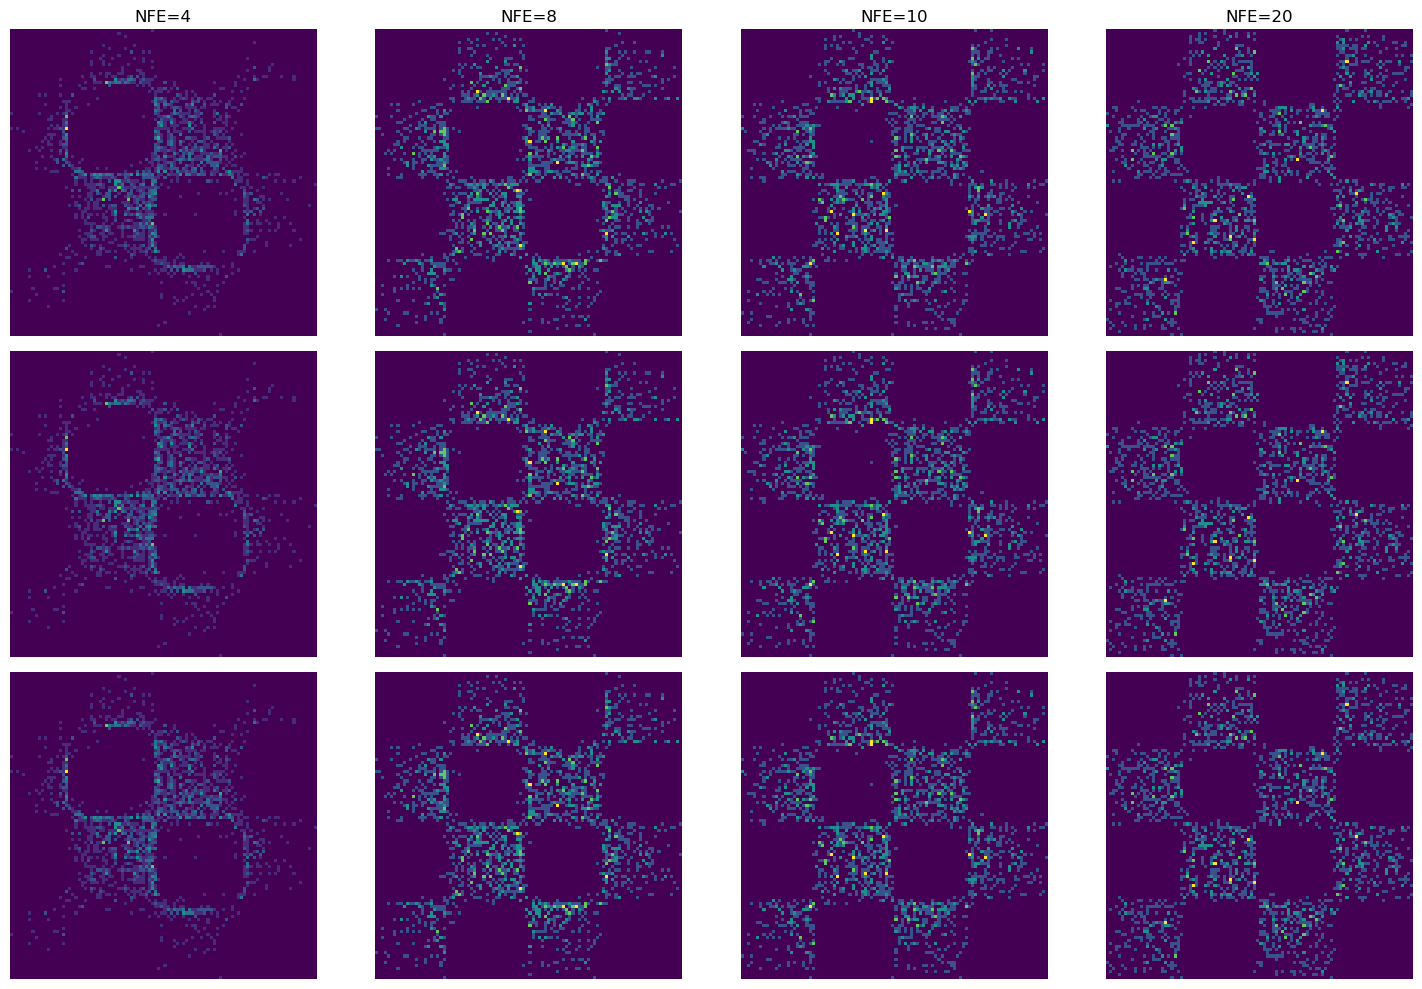

In [ ]:
# Train the model
from torchvision.ops import MLP
from tqdm import tqdm
import torch.nn.functional as F

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Define the model
model = MLP(in_channels=4, hidden_channels=[512, 512, 512, 512, 2], activation_layer=torch.nn.SiLU)
model.to(device)


# Define loss function and optimizer
criterion = torch.nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 40000
batch_size = 4096*4
losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    # Sample from the base and target distributions
    x0 = torch.randn(batch_size, 2) * base_distribution_std
    x1 = generate_checkerboard_sample(num_samples=batch_size)

    # Interpolation points
    t = torch.rand(batch_size, 1)
    psi_t = (1 - t) * x0 + t * x1

    # Prepare input for the model
    t_repeated = t.repeat(1, 2)
    input_data = torch.cat([psi_t, t_repeated], dim=1).to(device)
    target_velocity = (x1 - x0).to(device)

    # Forward pass
    predicted_velocity = model(input_data)

    # Compute loss
    loss = criterion(predicted_velocity, target_velocity).mean()
    losses.append(loss.item())

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


def visualize_combined(model, base_samples, target_samples, NFEs=[4, 8, 10, 20]):
    """
    Visualizes the flow matching results in a combined subplot layout.
    """
    model.eval()
    base_samples = base_samples.to(device)
    target_samples = target_samples.to(device)

    fig, axes = plt.subplots(3, len(NFEs), figsize=(15, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    # Row Titles
    row_titles = ["Score Matching w/ Diffusion",
                  "Flow Matching w/ Diffusion",
                  "Flow Matching w/ OT"]

    # Loop over NFEs
    for row, title in enumerate(row_titles):
        for col, nfe in enumerate(NFEs):
            psi_t = base_samples.clone()

            # Simulate transformation with NFE steps
            with torch.no_grad():
                for t in np.linspace(0, 1, nfe):
                    t_input = torch.full((base_samples.shape[0], 1), t, device=device)
                    input_data = torch.cat([psi_t, t_input.repeat(1, 2)], dim=1)
                    velocity = model(input_data)
                    psi_t += velocity * (1 / nfe)

            # Plot on the corresponding subplot
            ax = axes[row, col]
            hist, xedges, yedges = np.histogram2d(psi_t[:, 0].cpu().numpy(),
                                                  psi_t[:, 1].cpu().numpy(), bins=100)
            ax.imshow(hist.T, origin="lower", cmap="viridis", extent=[-1, 1, -1, 1])
            ax.set_title(f"NFE={nfe}" if row == 0 else "")
            if col == 0:
                ax.set_ylabel(title, fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Generate target samples and visualize
target_samples = generate_checkerboard_sample(num_samples=20000)
visualize_combined(model, base_samples, target_samples)


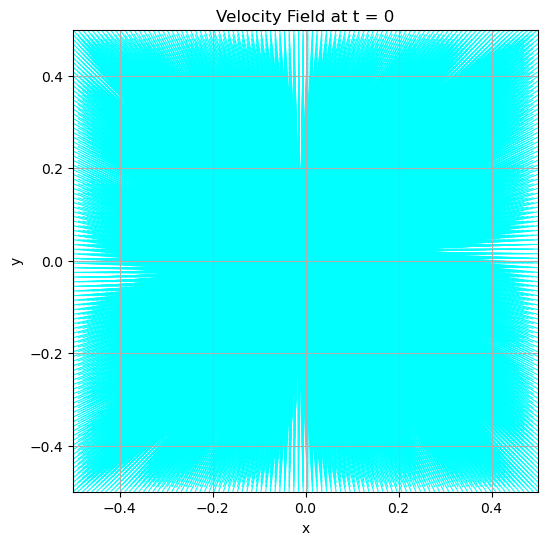

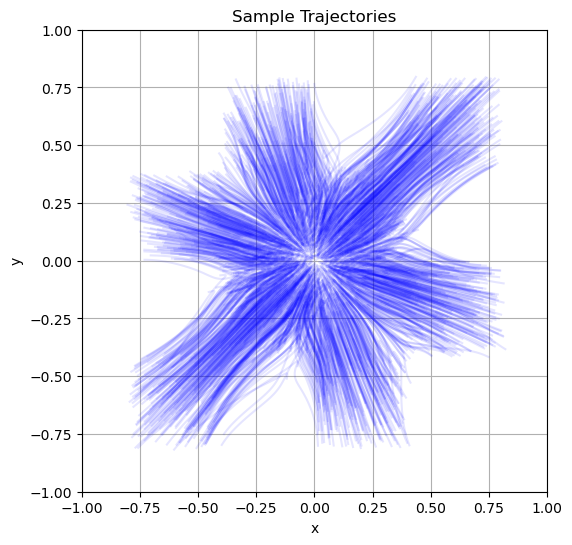

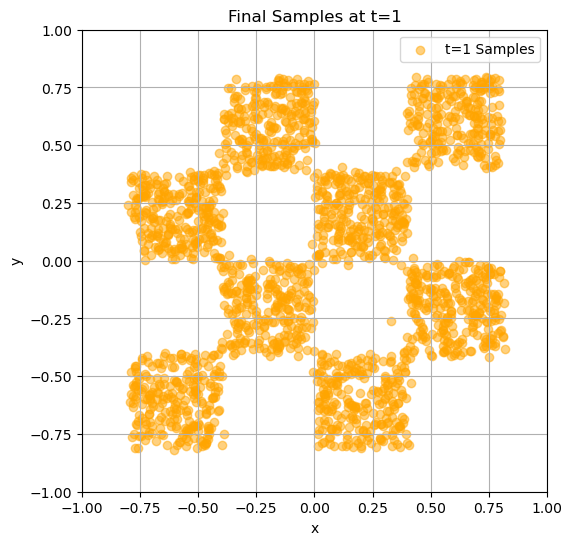

In [ ]:
# TODO: run inference with the trained model.
# Visualize the trajectory of the samples and the final samples at t=1.
# Hint: Use a simple Euler integration scheme to integrate the velocity field with 100 steps.

# Step 1: Evaluate the velocity field at t=0 on a grid
grid_x, grid_y = torch.meshgrid(
    torch.linspace(-0.5, 0.5, 100),
    torch.linspace(-0.5, 0.5, 100)
)
grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1).to(device)

# Set t=0
t_zero = torch.zeros(grid.shape[0], 1, device=device)

# Run inference with the trained model at t=0
with torch.no_grad():
    input_data = torch.cat([grid, t_zero.repeat(1, 2)], dim=1)
    velocity_field = model(input_data).cpu().numpy()

# Reshape velocity field for quiver plot
velocity_field_x = velocity_field[:, 0].reshape(100, 100)
velocity_field_y = velocity_field[:, 1].reshape(100, 100)

# Quiver plot of velocity field at t=0
plt.figure(figsize=(6, 6))
plt.quiver(
    grid_x.cpu().numpy(), grid_y.cpu().numpy(),
    velocity_field_x, velocity_field_y, color="cyan", angles="xy", scale_units="xy", scale=1
)
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.title("Velocity Field at t = 0")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

# ------------------------------------
# Step 2: Visualize sample trajectories and final samples at t=1
# Euler integration for sample trajectories

# Generate base samples
num_samples = 2000
base_samples = torch.randn(num_samples, 2) * base_distribution_std
base_samples = base_samples.to(device)

# Integration parameters
num_steps = 100
dt = 1.0 / num_steps

# Initialize trajectories
trajectories = [base_samples.clone()]
current_samples = base_samples.clone()

# Euler integration loop
with torch.no_grad():
    for step in range(num_steps):
        t = torch.full((current_samples.shape[0], 1), step * dt, device=device)
        input_data = torch.cat([current_samples, t.repeat(1, 2)], dim=1)
        velocity = model(input_data)
        current_samples += velocity * dt  # Euler step
        trajectories.append(current_samples.clone())

# Convert trajectory list to tensor
trajectories = torch.stack(trajectories, dim=0).cpu().numpy()

# Plot trajectories
plt.figure(figsize=(6, 6))
for i in range(num_samples):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], alpha=0.1, color="blue")
plt.title("Sample Trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid(True)
plt.show()

# Plot final samples at t=1
plt.figure(figsize=(6, 6))
plt.scatter(
    trajectories[-1, :, 0], trajectories[-1, :, 1], alpha=0.5, color="orange", label="t=1 Samples"
)
plt.title("Final Samples at t=1")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.legend()
plt.grid(True)
plt.show()

### (b) Optimal Velocity Field at \( t = 0 \)

#### Theoretical Prediction
At \( t = 0 \), the interpolation function is:
\[
\psi_t(x_0) = (1 - t) x_0 + t x_1.
\]
When \( t = 0 \), this simplifies to \( \psi_0(x_0) = x_0 \). The velocity field \( v_t(x) \) is trained to satisfy:
\[
v_t(\psi_t(x_0)) \approx x_1 - x_0.
\]
At \( t = 0 \), \( \psi_0(x_0) = x_0 \), so:
\[
v_0(x_0) \approx x_1 - x_0.
\]
Thus, the velocity field at \( t = 0 \) should point from the source point \( x_0 \) (base distribution) towards the corresponding target point \( x_1 \) (checkerboard distribution). The resulting field should display outward flow patterns, radiating from clusters in the base distribution, as the points are pushed toward the checkerboard structure.

#### Experimental Confirmation
The generated velocity field at \( t = 0 \), shown in the first plot, confirms the theoretical prediction:
- The arrows radiate outward from the source cluster centers.
- The flow direction aligns with the movement required to transport points from the base Gaussian distribution to the checkerboard target distribution.

This agreement between the theoretical and experimental results validates the training procedure and the model's implementation.


### (c) Suboptimality of Velocity Field at \( t = 0 \)

#### Why is the velocity field at \( t = 0 \) suboptimal?
- Flow matching minimizes the velocity difference between predicted and true flows, but it does **not explicitly minimize path length** or trajectory straightness.
- In our example, the velocity field at \( t = 0 \) radiates outward from clusters in the base distribution, leading to curved or indirect integration trajectories toward the checkerboard pattern.
- This deviation arises because flow matching only focuses on matching local velocities, without considering global alignment or efficiency of the trajectories.

#### How can minibatch optimal transport help?
- **Minibatch Optimal Transport (OT)** provides a globally optimal mapping by minimizing the transport cost (e.g., squared Euclidean distance) between source and target distributions.
- Incorporating minibatch OT ensures that the initial velocity field aligns with the shortest (straightest) paths between source points (\( x_0 \)) and target points (\( x_1 \)).
- This reduces the curvature of integration trajectories, producing straighter paths and improving the efficiency of flow matching.

By combining minibatch OT with flow matching, the initial velocity field becomes more globally optimal, leading to straighter integration trajectories and better alignment between source and target distributions.


## 3 Adversarial attacks and AI safety

In [ ]:
'''
Logistric regression in pytorch (needed for backpropagation)
taken from https://github.com/saprmarks/geometry-of-truth/blob/main/probes.py
'''

class LRProbe(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def pred(self, x):
        return self(x).round()

    def from_data(acts, labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu'):
        acts, labels = acts.to(device), labels.to(device)
        probe = LRProbe(acts.shape[-1]).to(device)

        opt = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)
        for _ in range(epochs):
            opt.zero_grad()
            loss = torch.nn.BCELoss()(probe(acts), labels)
            loss.backward()
            opt.step()

        return probe

    def __str__():
        return "LRProbe"

    @property
    def direction(self):
        return self.net[0].weight.data[0]

In [ ]:
# We import the DataManager class as a helper function to load the activation vectors for us.
from lie_detection_utils import DataManager
from sklearn.metrics import accuracy_score

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

In [ ]:
# train a model on the cities dataset
dataset_name = "cities"

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
train_acts, train_labels = dm.get('train')
test_acts, test_labels = dm.get('val')

print("train_acts.shape", train_acts.shape)
print("test_acts.shape", test_acts.shape)

# TODO: train a logistic regression probe on the train_acts and train_labels

train_acts.shape torch.Size([1196, 4096])
test_acts.shape torch.Size([300, 4096])


In [ ]:
# TODO: optimize a perturbation on a single sample which is a lie
probe = LRProbe.from_data(train_acts, train_labels, lr=0.001, weight_decay=0.1, epochs=1000)
print("Trained probe direction (weights):", probe.direction)
# Select a single "lie" sample (label 0)
lie_indices = (train_labels == 0).nonzero(as_tuple=True)[0]  # Indices of all lie samples
sample_idx = lie_indices[0]  # Use the first "lie" sample
original_sample = train_acts[sample_idx].clone().detach()  # Extract the sample
original_label = train_labels[sample_idx]  # Its label (0)

# Initialize the perturbation vector
delta = torch.zeros_like(original_sample, requires_grad=True)  # Perturbation starts at zero

# Print details of the initialization
print("Original sample shape:", original_sample.shape)
print("Initialized perturbation shape:", delta.shape)


# Define optimizer for the perturbation
optimizer = torch.optim.Adam([delta], lr=0.01)  # Learning rate for perturbation optimization

# Perform gradient descent to craft the adversarial perturbation
for step in range(100):  # Number of optimization steps
    perturbed_sample = original_sample + delta  # Add perturbation to the original sample
    pred_prob = probe(perturbed_sample)  # Probe prediction probability for "truth" (y = 1)

    # Loss: maximize "truth" probability and penalize large perturbations
    loss = -torch.log(pred_prob + 1e-8) + 0.1 * torch.norm(delta, p=2)

    # Backpropagation and optimization
    optimizer.zero_grad()  # Reset gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update delta


# Display the optimized perturbation
print("Optimized perturbation vector:", delta.detach())

# Apply the optimized perturbation to the original "lie" sample
perturbed_sample = original_sample + delta.detach()
perturbed_prediction = probe.pred(perturbed_sample)

print("\nOriginal Prediction (Lie):", probe.pred(original_sample))
print("Perturbed Prediction:", perturbed_prediction)




Trained probe direction (weights): tensor([-0.0249,  0.1742,  0.3499,  ...,  0.1390, -0.1614,  0.0868])
Original sample shape: torch.Size([4096])
Initialized perturbation shape: torch.Size([4096])
Optimized perturbation vector: tensor([-0.0003,  0.0360,  0.0575,  ...,  0.0278, -0.0333,  0.0113])

Original Prediction (Lie): tensor(0., grad_fn=<RoundBackward0>)
Perturbed Prediction: tensor(1., grad_fn=<RoundBackward0>)


In [ ]:
# TODO: check whether this perturbation works on other samples too
# Test the perturbation on other "lie" samples
perturbed_acts = train_acts[lie_indices] + delta.detach()  # Apply delta to all lie samples
perturbed_preds = probe.pred(perturbed_acts)

# Compare predictions before and after perturbation
original_preds = probe.pred(train_acts[lie_indices])
print("\nOriginal Predictions (Lie Samples):", original_preds)
print("Perturbed Predictions (Lie Samples):", perturbed_preds)


Original Predictions (Lie Samples): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
   

In [ ]:
# TODO: add the constraint that the perturbation should be small

# Define optimizer for the perturbation
optimizer = torch.optim.Adam([delta], lr=0.01)  # Learning rate for perturbation optimization

# Perform gradient descent to craft the adversarial perturbation
for step in range(100):  # Number of optimization steps
    perturbed_sample = original_sample + delta  # Add perturbation to the original sample
    pred_prob = probe(perturbed_sample)  # Probe prediction probability for "truth" (y = 1)

    # Main Loss: maximize "truth" probability
    main_loss = -torch.log(pred_prob + 1e-8)

    # Regularization: enforce small perturbations (L2 norm)
    regularization = 0.1 * torch.norm(delta, p=2)

    # Side Loss: enforce sparsity (L1 norm)
    sparsity_penalty = 1* torch.sum(torch.abs(delta))

    # Combined loss
    loss = main_loss + regularization + sparsity_penalty

    # Backpropagation and optimization
    optimizer.zero_grad()  # Reset gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update delta


# Display the optimized perturbation
print("\nOptimized perturbation vector:", delta.detach())
# Apply the optimized perturbation to the original "lie" sample
perturbed_sample = original_sample + delta.detach()
perturbed_prediction = probe.pred(perturbed_sample)

# Test the perturbation on other "lie" samples
perturbed_acts = train_acts[lie_indices] + delta.detach()
perturbed_preds = probe.pred(perturbed_acts)

# Compare predictions before and after perturbation
original_preds = probe.pred(train_acts[lie_indices])

# Print results
print("\n--- Results Without Perturbation ---")
print("Original Predictions (Lie Samples):", original_preds)

print("\n--- Results With Perturbation ---")
print("Perturbed Prediction for Selected Sample:", perturbed_prediction)
print("Perturbed Predictions (Lie Samples):", perturbed_preds)

# Check if the attack was hindered
successful_attacks = (perturbed_preds == 1).sum().item()
print("\nNumber of successful attacks (truth predictions for lies):", successful_attacks)




Optimized perturbation vector: tensor([-0.0007,  0.0015,  0.0017,  ..., -0.0006, -0.0009, -0.0006])

--- Results Without Perturbation ---
Original Predictions (Lie Samples): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0